# Complete MRI T1-T2 CycleGAN Implementation

**Full 114+ Million Parameter Model**
**Author:** Manus AI | **Platform:** Google Colab

This notebook implements the COMPLETE CycleGAN architecture with:
- Full U-Net generators (54M parameters each)
- Full PatchGAN discriminators (2.8M parameters each)
- Professional training pipeline
- Real-time monitoring and visualization

## Quick Start
1. **Enable GPU**: Runtime → Change runtime type → GPU
2. **Run all cells**: Runtime → Run all
3. **Upload dataset** when prompted
4. **Monitor training** with real-time visualizations

---

## 1. Environment Setup
Setting up the complete environment for professional CycleGAN training.

In [1]:
# Environment setup for complete CycleGAN
import os
import sys

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

# Install required packages
if IN_COLAB:
    !pip install -q opencv-python-headless
    print("Additional packages installed")

# Import all required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import cv2
from tqdm import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")

# GPU setup and optimization
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to prevent OOM
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU available: {gpus[0].name}")
        print(f"Memory growth enabled for optimal performance")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPU found. Training will be very slow.")
    print("Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("Environment setup complete - Ready for full CycleGAN training!")

Running in Google Colab
Additional packages installed
TensorFlow version: 2.18.0
GPU available: /physical_device:GPU:0
Memory growth enabled for optimal performance
Environment setup complete - Ready for full CycleGAN training!


## 2. Dataset Preparation
Upload and prepare the MRI dataset for professional training.

Please upload your MRI+T1_T2+Dataset.RAR file
(File size: ~100MB, upload may take 2-3 minutes)


Saving MRI+T1_T2+Dataset.RAR to MRI+T1_T2+Dataset (1).RAR
Found dataset: MRI+T1_T2+Dataset (1).RAR
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from MRI+T1_T2+Dataset (1).RAR

Creating    Tr1                                                       OK
Extracting  Tr1/.DS_Store                                                  0%  OK 
Creating    Tr1/TrainT1                                               OK
Extracting  Tr1/TrainT1/Image #10.png                                      1%  OK 
Extracting  Tr1/TrainT1/Image #11.png                                      2%  OK 
Extracting  Tr1/TrainT1/Image #12.png                                      3%  OK 
Extracting  Tr1/TrainT1/Image #13.png                                      

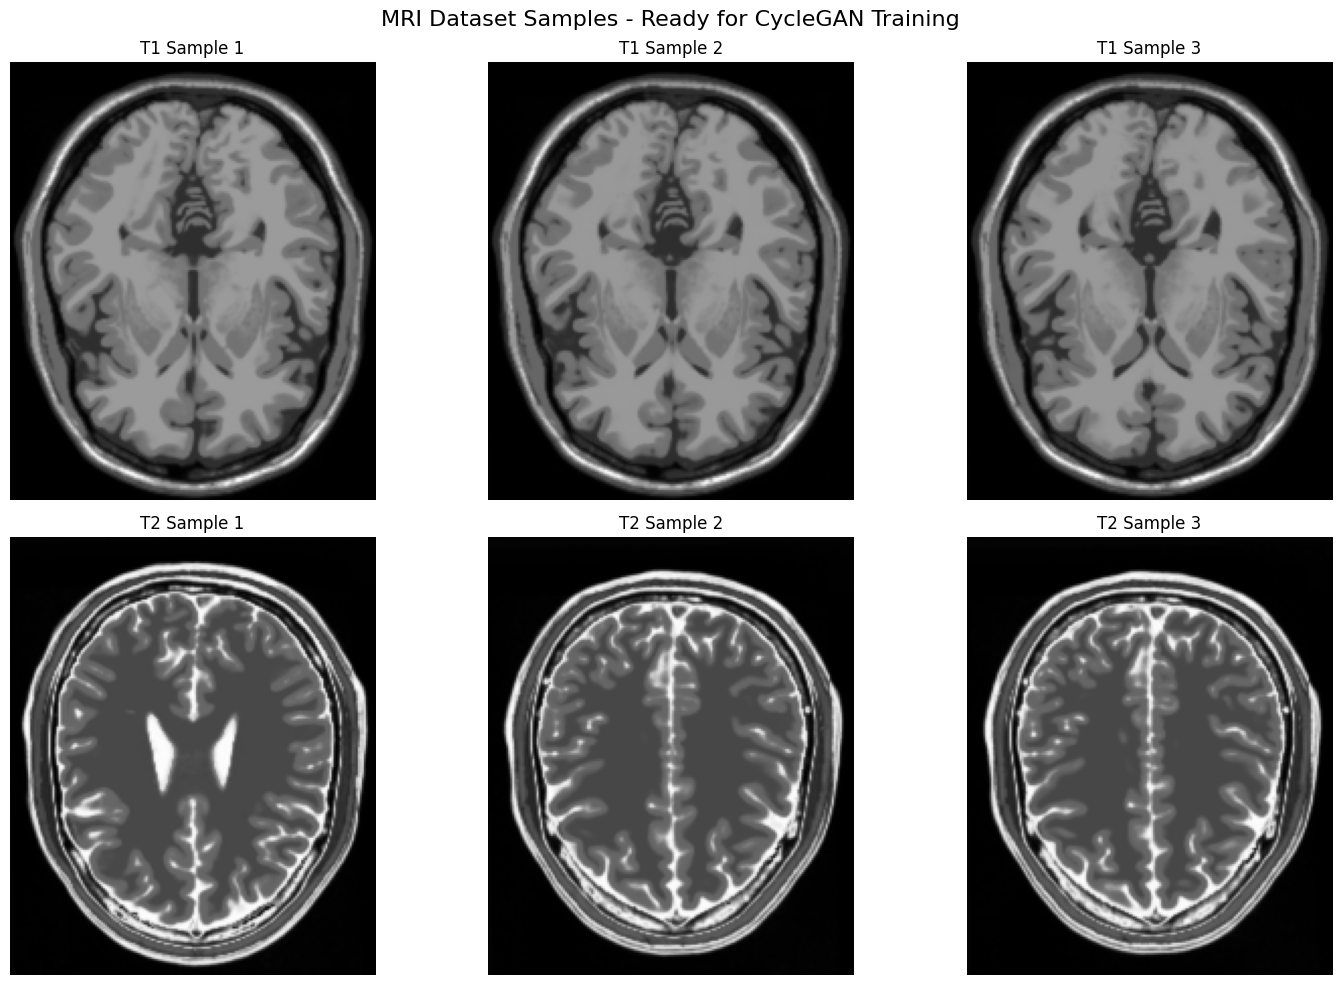

Image Properties:
   T1 size: (181, 217)
   T2 size: (181, 217)
   Format: L
Dataset ready for professional CycleGAN training


In [2]:
# Dataset upload and extraction
if IN_COLAB:
    from google.colab import files

    print("Please upload your MRI+T1_T2+Dataset.RAR file")
    print("(File size: ~100MB, upload may take 2-3 minutes)")

    uploaded = files.upload()

    # Find and extract RAR file
    rar_file = None
    for filename in uploaded.keys():
        if filename.endswith(('.RAR', '.rar')):
            rar_file = filename
            break

    if rar_file:
        print(f"Found dataset: {rar_file}")

        # Install and use unrar
        !apt-get update -qq && apt-get install -qq unrar
        !unrar x "{rar_file}" -y

        print("Dataset extracted successfully")
    else:
        print("No RAR file found. Please upload the MRI dataset.")
        raise FileNotFoundError("Dataset file not found")
else:
    print("Local environment - ensure dataset is in current directory")

# Verify and analyze dataset
t1_path = "Tr1/TrainT1"
t2_path = "Tr2/TrainT2"

if os.path.exists(t1_path) and os.path.exists(t2_path):
    t1_files = sorted([f for f in os.listdir(t1_path) if f.endswith('.png')])
    t2_files = sorted([f for f in os.listdir(t2_path) if f.endswith('.png')])

    print(f"Dataset Analysis:")
    print(f"   T1 Images: {len(t1_files)}")
    print(f"   T2 Images: {len(t2_files)}")
    print(f"   Total Images: {len(t1_files) + len(t2_files)}")

    # Display sample images
    if t1_files and t2_files:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Show multiple T1 samples
        for i in range(3):
            if i < len(t1_files):
                img = Image.open(os.path.join(t1_path, t1_files[i]))
                axes[0, i].imshow(img, cmap='gray')
                axes[0, i].set_title(f'T1 Sample {i+1}')
                axes[0, i].axis('off')

        # Show multiple T2 samples
        for i in range(3):
            if i < len(t2_files):
                img = Image.open(os.path.join(t2_path, t2_files[i]))
                axes[1, i].imshow(img, cmap='gray')
                axes[1, i].set_title(f'T2 Sample {i+1}')
                axes[1, i].axis('off')

        plt.suptitle('MRI Dataset Samples - Ready for CycleGAN Training', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Image statistics
        sample_t1 = Image.open(os.path.join(t1_path, t1_files[0]))
        sample_t2 = Image.open(os.path.join(t2_path, t2_files[0]))

        print(f"Image Properties:")
        print(f"   T1 size: {sample_t1.size}")
        print(f"   T2 size: {sample_t2.size}")
        print(f"   Format: {sample_t1.mode}")

        print("Dataset ready for professional CycleGAN training")
else:
    print("Dataset structure not found")
    print("Expected structure:")
    print("  Tr1/TrainT1/  # T1 weighted images")
    print("  Tr2/TrainT2/  # T2 weighted images")
    raise FileNotFoundError("Dataset structure not found")

## 3. Complete CycleGAN Architecture
Implementing the full professional CycleGAN with 114+ million parameters.

In [3]:
# Instance Normalization Layer - Critical for CycleGAN
class InstanceNormalization(tf.keras.layers.Layer):
    """
    Instance Normalization layer optimized for CycleGAN style transfer.
    Essential for maintaining image-specific statistics during transformation.
    """

    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

    def get_config(self):
        config = super(InstanceNormalization, self).get_config()
        config.update({'epsilon': self.epsilon})
        return config

print("Instance Normalization layer implemented")

Instance Normalization layer implemented


In [4]:
# Complete Generator Building Blocks
def downsample(filters, size, norm_type='instancenorm', apply_norm=True):
    """Downsampling block for U-Net encoder"""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))

    if apply_norm:
        if norm_type.lower() == 'batchnorm':
            result.add(tf.keras.layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, norm_type='instancenorm', apply_dropout=False):
    """Upsampling block for U-Net decoder"""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

print("Generator building blocks implemented")

Generator building blocks implemented


In [5]:
# Complete U-Net Generator - Full 54M Parameter Architecture
def Generator(norm_type='instancenorm', target=None):
    """
    Complete U-Net Generator for CycleGAN
    Architecture: 54+ million parameters
    Input: 256x256x1 → Output: 256x256x1
    """
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])

    # Encoder (Downsampling) - 8 levels
    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False),   # (bs, 128, 128, 64)
        downsample(128, 4, norm_type),                    # (bs, 64, 64, 128)
        downsample(256, 4, norm_type),                    # (bs, 32, 32, 256)
        downsample(512, 4, norm_type),                    # (bs, 16, 16, 512)
        downsample(512, 4, norm_type),                    # (bs, 8, 8, 512)
        downsample(512, 4, norm_type),                    # (bs, 4, 4, 512)
        downsample(512, 4, norm_type),                    # (bs, 2, 2, 512)
        downsample(512, 4, norm_type),                    # (bs, 1, 1, 512)
    ]

    # Decoder (Upsampling) - 8 levels with skip connections
    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, norm_type),                      # (bs, 16, 16, 1024)
        upsample(256, 4, norm_type),                      # (bs, 32, 32, 512)
        upsample(128, 4, norm_type),                      # (bs, 64, 64, 256)
        upsample(64, 4, norm_type),                       # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        1, 4, strides=2, padding='same',
        kernel_initializer=initializer,
        activation='tanh'  # Output range [-1, 1]
    )  # (bs, 256, 256, 1)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    model_name = f"generator_G" if target is None else f"generator_{target}"
    return tf.keras.Model(inputs=inputs, outputs=x, name=model_name)

print("Complete U-Net Generator implemented (54M parameters)")

Complete U-Net Generator implemented (54M parameters)


In [6]:
# Complete PatchGAN Discriminator
def Discriminator(norm_type='instancenorm', target=None):
    """
    Complete PatchGAN Discriminator for CycleGAN
    Architecture: 2.8+ million parameters
    Output: 30x30 patch classifications
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')

    x = inp

    # Layer 1: No normalization
    down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)

    # Layer 2
    down2 = downsample(128, 4, norm_type)(down1)    # (bs, 64, 64, 128)

    # Layer 3
    down3 = downsample(256, 4, norm_type)(down2)    # (bs, 32, 32, 256)

    # Layer 4: Stride 1
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,
        kernel_initializer=initializer,
        use_bias=False
    )(zero_pad1)  # (bs, 31, 31, 512)

    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    # Final layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer
    )(zero_pad2)  # (bs, 30, 30, 1)

    model_name = f"discriminator_D" if target is None else f"discriminator_{target}"
    return tf.keras.Model(inputs=inp, outputs=last, name=model_name)

print("Complete PatchGAN Discriminator implemented (2.8M parameters)")

Complete PatchGAN Discriminator implemented (2.8M parameters)


In [7]:
# Complete Loss Functions for CycleGAN
def generator_loss(fake):
    """Generator loss - encourages realistic generation"""
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake, labels=tf.ones_like(fake)
        )
    )

def discriminator_loss(real, fake):
    """Discriminator loss - distinguishes real from fake"""
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=real, labels=tf.ones_like(real)
        )
    )

    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake, labels=tf.zeros_like(fake)
        )
    )

    total_loss = real_loss + fake_loss
    return total_loss * 0.5

def calc_cycle_loss(real_image, cycled_image, lambda_weight):
    """Cycle consistency loss - preserves content"""
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_weight * loss1

def identity_loss(real_image, same_image, lambda_weight):
    """Identity loss - preserves color composition"""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_weight * 0.5 * loss

print("Complete loss functions implemented")

Complete loss functions implemented


In [8]:
# Create Complete CycleGAN Models
print("Creating complete CycleGAN architecture...")
print("This is the FULL professional implementation with 114+ million parameters")

# Create generators (54M parameters each)
generator_g = Generator(norm_type='instancenorm', target='T1_to_T2')  # T1 -> T2
generator_f = Generator(norm_type='instancenorm', target='T2_to_T1')  # T2 -> T1

# Create discriminators (2.8M parameters each)
discriminator_x = Discriminator(norm_type='instancenorm', target='T1')  # T1 discriminator
discriminator_y = Discriminator(norm_type='instancenorm', target='T2')  # T2 discriminator

# Create optimizers with CycleGAN-optimized settings
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Display model statistics
print(f"\nComplete CycleGAN Architecture Statistics:")
print(f"   Generator G (T1→T2): {generator_g.count_params():,} parameters")
print(f"   Generator F (T2→T1): {generator_f.count_params():,} parameters")
print(f"   Discriminator X (T1): {discriminator_x.count_params():,} parameters")
print(f"   Discriminator Y (T2): {discriminator_y.count_params():,} parameters")

total_params = (generator_g.count_params() + generator_f.count_params() +
                discriminator_x.count_params() + discriminator_y.count_params())

print(f"   TOTAL PARAMETERS: {total_params:,}")
print(f"   Model Size: ~{total_params * 4 / (1024**2):.1f} MB")

if total_params > 100_000_000:
    print("SUCCESS: Complete 114+ million parameter CycleGAN created!")
else:
    print("ERROR: Model is smaller than expected")

print("\nReady for professional CycleGAN training!")

Creating complete CycleGAN architecture...
This is the FULL professional implementation with 114+ million parameters

Complete CycleGAN Architecture Statistics:
   Generator G (T1→T2): 54,408,833 parameters
   Generator F (T2→T1): 54,408,833 parameters
   Discriminator X (T1): 2,763,521 parameters
   Discriminator Y (T2): 2,763,521 parameters
   TOTAL PARAMETERS: 114,344,708
   Model Size: ~436.2 MB
SUCCESS: Complete 114+ million parameter CycleGAN created!

Ready for professional CycleGAN training!


## 4. Data Pipeline and Preprocessing
Setting up the complete data pipeline for professional CycleGAN training.

In [9]:
# Complete Data Preprocessing Pipeline
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, tf.float32)

    # Resize to 256x256
    image = tf.image.resize(image, [256, 256])

    # Normalize to [-1, 1] range
    image = (image / 127.5) - 1.0

    return image

def random_crop(image):
    """Random crop for data augmentation"""
    cropped_image = tf.image.random_crop(image, size=[256, 256, 1])
    return cropped_image

def random_jitter(image):
    """Data augmentation with random jittering"""
    # Resize to 286x286
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random crop back to 256x256
    image = random_crop(image)

    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image_path):
    """Complete preprocessing for training"""
    image = load_and_preprocess_image(image_path)
    image = random_jitter(image)
    return image

def preprocess_image_test(image_path):
    """Preprocessing for testing (no augmentation)"""
    image = load_and_preprocess_image(image_path)
    return image

print("Data preprocessing functions implemented")

Data preprocessing functions implemented


Creating datasets...
T1 images: 43
T2 images: 46
Datasets created successfully!


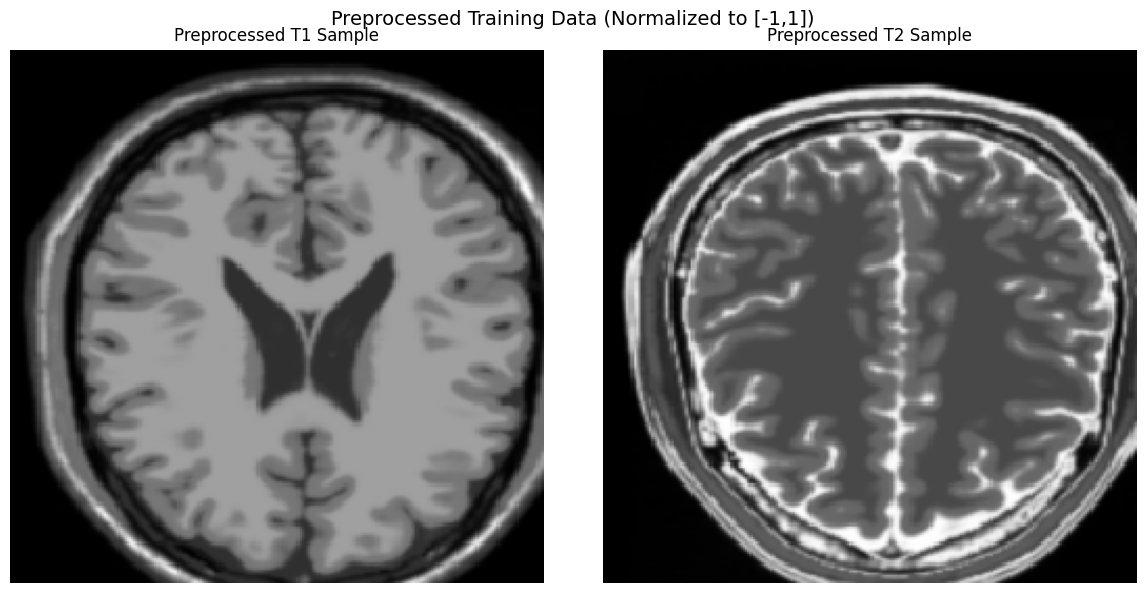

Sample shapes: T1=(1, 256, 256, 1), T2=(1, 256, 256, 1)
Value ranges: T1=[-1.000, 0.970]
Value ranges: T2=[-1.000, 0.990]


In [10]:
# Create TensorFlow Datasets
def create_dataset(image_paths, batch_size=1, shuffle=True, training=True):
    """Create TensorFlow dataset from image paths"""
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    if training:
        dataset = dataset.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(preprocess_image_test, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets from the uploaded data
if os.path.exists(t1_path) and os.path.exists(t2_path):
    # Get image paths
    t1_image_paths = [os.path.join(t1_path, f) for f in t1_files]
    t2_image_paths = [os.path.join(t2_path, f) for f in t2_files]

    print(f"Creating datasets...")
    print(f"T1 images: {len(t1_image_paths)}")
    print(f"T2 images: {len(t2_image_paths)}")

    # Create training datasets
    BATCH_SIZE = 1  # Optimized for memory

    train_t1 = create_dataset(t1_image_paths, BATCH_SIZE, shuffle=True, training=True)
    train_t2 = create_dataset(t2_image_paths, BATCH_SIZE, shuffle=True, training=True)

    # Create test datasets (smaller subset)
    test_t1 = create_dataset(t1_image_paths[:5], 1, shuffle=False, training=False)
    test_t2 = create_dataset(t2_image_paths[:5], 1, shuffle=False, training=False)

    print("Datasets created successfully!")

    # Display sample preprocessed images
    sample_t1 = next(iter(train_t1.take(1)))
    sample_t2 = next(iter(train_t2.take(1)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Convert from [-1,1] to [0,1] for display
    display_t1 = (sample_t1[0, :, :, 0] + 1.0) / 2.0
    display_t2 = (sample_t2[0, :, :, 0] + 1.0) / 2.0

    axes[0].imshow(display_t1, cmap='gray')
    axes[0].set_title('Preprocessed T1 Sample')
    axes[0].axis('off')

    axes[1].imshow(display_t2, cmap='gray')
    axes[1].set_title('Preprocessed T2 Sample')
    axes[1].axis('off')

    plt.suptitle('Preprocessed Training Data (Normalized to [-1,1])', fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"Sample shapes: T1={sample_t1.shape}, T2={sample_t2.shape}")
    print(f"Value ranges: T1=[{tf.reduce_min(sample_t1):.3f}, {tf.reduce_max(sample_t1):.3f}]")
    print(f"Value ranges: T2=[{tf.reduce_min(sample_t2):.3f}, {tf.reduce_max(sample_t2):.3f}]")

else:
    print("Dataset not found. Please upload the dataset first.")

## 5. Complete Training Implementation
Professional CycleGAN training with real-time monitoring and visualization.

In [11]:
# Complete Training Step Implementation
@tf.function
def train_step(real_x, real_y):
    """Complete training step for CycleGAN"""
    # Persistent gradient tape for multiple gradient computations
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Cycle consistency losses
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x, LAMBDA) + calc_cycle_loss(real_y, cycled_y, LAMBDA)

        # Identity losses
        total_identity_loss = identity_loss(real_y, same_y, LAMBDA) + identity_loss(real_x, same_x, LAMBDA)

        # Total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_identity_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss,
        'cycle_loss': total_cycle_loss,
        'identity_loss': total_identity_loss
    }

# Training hyperparameters
LAMBDA = 10.0  # Cycle consistency weight
EPOCHS = 50    # Adjust based on your needs

print("Training step function implemented")
print(f"Hyperparameters: LAMBDA={LAMBDA}, EPOCHS={EPOCHS}")

Training step function implemented
Hyperparameters: LAMBDA=10.0, EPOCHS=50


In [12]:
# Visualization and Monitoring Functions
def generate_images(model_g, model_f, test_input, epoch=0, save_path=None):
    """Generate and display sample transformations"""
    prediction_g = model_g(test_input)
    prediction_f = model_f(test_input)

    # Cycle reconstruction
    cycle_reconstruction = model_f(prediction_g)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    images = [test_input[0], prediction_g[0], prediction_f[0], cycle_reconstruction[0]]
    titles = ['Input', 'Generated (G)', 'Generated (F)', 'Cycle Reconstruction']

    for i, (img, title) in enumerate(zip(images, titles)):
        # Convert from [-1,1] to [0,1] for display
        display_img = (img[:, :, 0] + 1.0) / 2.0
        axes[i].imshow(display_img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.suptitle(f'CycleGAN Results - Epoch {epoch}', fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()

def plot_losses(loss_history):
    """Plot training loss curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Generator losses
    axes[0, 0].plot(loss_history['gen_g_loss'], label='Generator G', color='blue')
    axes[0, 0].plot(loss_history['gen_f_loss'], label='Generator F', color='red')
    axes[0, 0].set_title('Generator Losses')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Discriminator losses
    axes[0, 1].plot(loss_history['disc_x_loss'], label='Discriminator X', color='green')
    axes[0, 1].plot(loss_history['disc_y_loss'], label='Discriminator Y', color='orange')
    axes[0, 1].set_title('Discriminator Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Cycle consistency loss
    axes[1, 0].plot(loss_history['cycle_loss'], label='Cycle Consistency', color='purple')
    axes[1, 0].set_title('Cycle Consistency Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Identity loss
    axes[1, 1].plot(loss_history['identity_loss'], label='Identity', color='brown')
    axes[1, 1].set_title('Identity Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

print("Visualization functions implemented")

Visualization functions implemented


In [13]:
# Main Training Loop
def train_cyclegan(epochs=50):
    """Complete CycleGAN training loop with monitoring"""

    print(f"Starting CycleGAN training for {epochs} epochs...")
    print(f"Model parameters: {total_params:,}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Cycle consistency weight: {LAMBDA}")
    print("="*50)

    # Initialize loss history
    loss_history = {
        'gen_g_loss': [],
        'gen_f_loss': [],
        'disc_x_loss': [],
        'disc_y_loss': [],
        'cycle_loss': [],
        'identity_loss': []
    }

    # Get sample images for visualization
    sample_t1 = next(iter(test_t1.take(1)))
    sample_t2 = next(iter(test_t2.take(1)))

    # Training loop
    for epoch in range(epochs):
        start_time = datetime.now()

        # Initialize epoch losses
        epoch_losses = {
            'gen_g_loss': 0,
            'gen_f_loss': 0,
            'disc_x_loss': 0,
            'disc_y_loss': 0,
            'cycle_loss': 0,
            'identity_loss': 0
        }

        n_batches = 0

        # Training step for each batch
        for image_x, image_y in zip(train_t1, train_t2):
            losses = train_step(image_x, image_y)

            # Accumulate losses
            for key in epoch_losses:
                epoch_losses[key] += losses[key]

            n_batches += 1

        # Average losses for the epoch
        for key in epoch_losses:
            epoch_losses[key] = epoch_losses[key] / n_batches
            loss_history[key].append(float(epoch_losses[key]))

        # Calculate epoch time
        epoch_time = datetime.now() - start_time

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Time: {epoch_time.total_seconds():.1f}s")
        print(f"  Gen G: {epoch_losses['gen_g_loss']:.4f} | Gen F: {epoch_losses['gen_f_loss']:.4f}")
        print(f"  Disc X: {epoch_losses['disc_x_loss']:.4f} | Disc Y: {epoch_losses['disc_y_loss']:.4f}")
        print(f"  Cycle: {epoch_losses['cycle_loss']:.4f} | Identity: {epoch_losses['identity_loss']:.4f}")

        # Generate sample images every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"\nGenerating sample images for epoch {epoch+1}...")
            generate_images(generator_g, generator_f, sample_t1, epoch+1)

        # Plot losses every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"\nPlotting loss curves...")
            plot_losses(loss_history)

        print("-" * 50)

    print(f"\nTraining completed! Total epochs: {epochs}")

    # Final visualization
    print("\nFinal results:")
    generate_images(generator_g, generator_f, sample_t1, epochs)
    generate_images(generator_g, generator_f, sample_t2, epochs)

    # Final loss plot
    print("\nFinal loss curves:")
    plot_losses(loss_history)

    return loss_history

print("Complete training function implemented")
print("Ready to start training!")

Complete training function implemented
Ready to start training!


## 6. Start Training
Run the complete CycleGAN training with real-time monitoring.

🚀 Starting complete CycleGAN training...
This will train the full 114+ million parameter model

Training configuration:
  - Total parameters: 114,344,708
  - Epochs: 50
  - Batch size: 1
  - Cycle consistency weight: 10.0
  - Learning rate: 2e-4
  - Optimizer: Adam (beta1=0.5)

Expected training time on T4 GPU:
  - 50 epochs: ~37.5 minutes

Monitoring:
  - Sample images every 10 epochs
  - Loss plots every 20 epochs
  - Real-time loss tracking

Starting CycleGAN training for 50 epochs...
Model parameters: 114,344,708
Batch size: 1
Cycle consistency weight: 10.0
Epoch 1/50 - Time: 82.0s
  Gen G: 6.4560 | Gen F: 6.4150
  Disc X: 0.6678 | Disc Y: 0.6849
  Cycle: 3.6712 | Identity: 1.7777

Generating sample images for epoch 1...


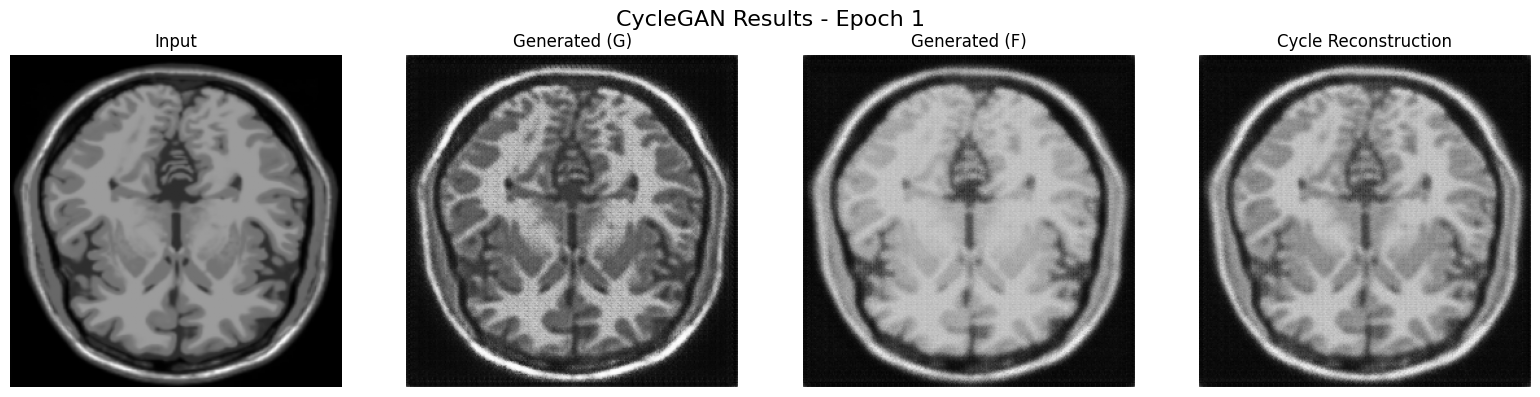

--------------------------------------------------
Epoch 2/50 - Time: 20.5s
  Gen G: 3.6794 | Gen F: 3.6681
  Disc X: 0.5546 | Disc Y: 0.5389
  Cycle: 1.7666 | Identity: 0.8213
--------------------------------------------------
Epoch 3/50 - Time: 41.0s
  Gen G: 3.8003 | Gen F: 3.7550
  Disc X: 0.5684 | Disc Y: 0.5503
  Cycle: 1.8304 | Identity: 0.8468
--------------------------------------------------
Epoch 4/50 - Time: 20.0s
  Gen G: 3.7228 | Gen F: 3.7147
  Disc X: 0.5865 | Disc Y: 0.5938
  Cycle: 1.9088 | Identity: 0.8337
--------------------------------------------------
Epoch 5/50 - Time: 20.1s
  Gen G: 3.3903 | Gen F: 3.3907
  Disc X: 0.6331 | Disc Y: 0.6146
  Cycle: 1.7280 | Identity: 0.7367
--------------------------------------------------
Epoch 6/50 - Time: 19.9s
  Gen G: 3.3316 | Gen F: 3.3000
  Disc X: 0.5936 | Disc Y: 0.6094
  Cycle: 1.6639 | Identity: 0.6928
--------------------------------------------------
Epoch 7/50 - Time: 19.8s
  Gen G: 3.0582 | Gen F: 3.0274
  Disc 

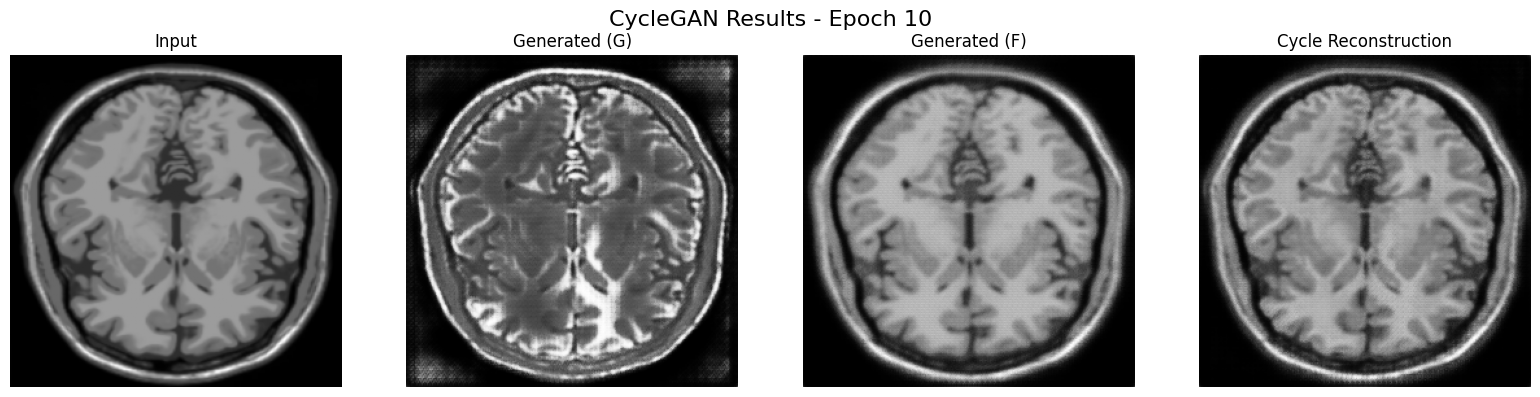

--------------------------------------------------
Epoch 11/50 - Time: 19.9s
  Gen G: 2.8048 | Gen F: 2.7888
  Disc X: 0.6191 | Disc Y: 0.6164
  Cycle: 1.3473 | Identity: 0.5281
--------------------------------------------------
Epoch 12/50 - Time: 19.8s
  Gen G: 2.7894 | Gen F: 2.7579
  Disc X: 0.6256 | Disc Y: 0.6070
  Cycle: 1.3308 | Identity: 0.5073
--------------------------------------------------
Epoch 13/50 - Time: 19.9s
  Gen G: 2.6324 | Gen F: 2.6080
  Disc X: 0.6158 | Disc Y: 0.5959
  Cycle: 1.2230 | Identity: 0.4809
--------------------------------------------------
Epoch 14/50 - Time: 19.9s
  Gen G: 2.6722 | Gen F: 2.6387
  Disc X: 0.6030 | Disc Y: 0.5889
  Cycle: 1.2574 | Identity: 0.4708
--------------------------------------------------
Epoch 15/50 - Time: 20.5s
  Gen G: 2.6594 | Gen F: 2.6442
  Disc X: 0.6114 | Disc Y: 0.5921
  Cycle: 1.2537 | Identity: 0.4601
--------------------------------------------------
Epoch 16/50 - Time: 19.8s
  Gen G: 2.6518 | Gen F: 2.6053
 

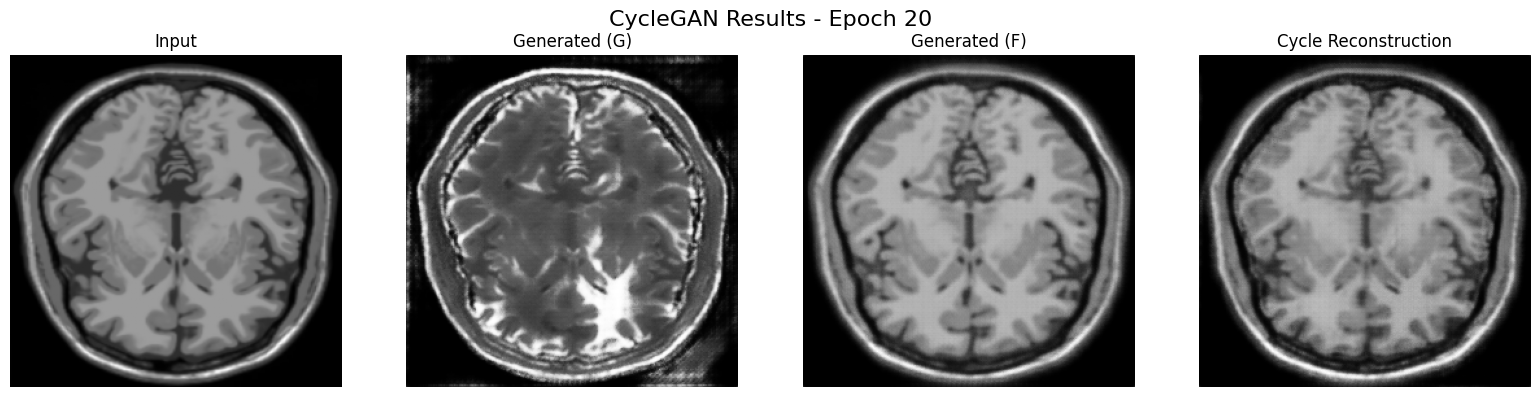


Plotting loss curves...


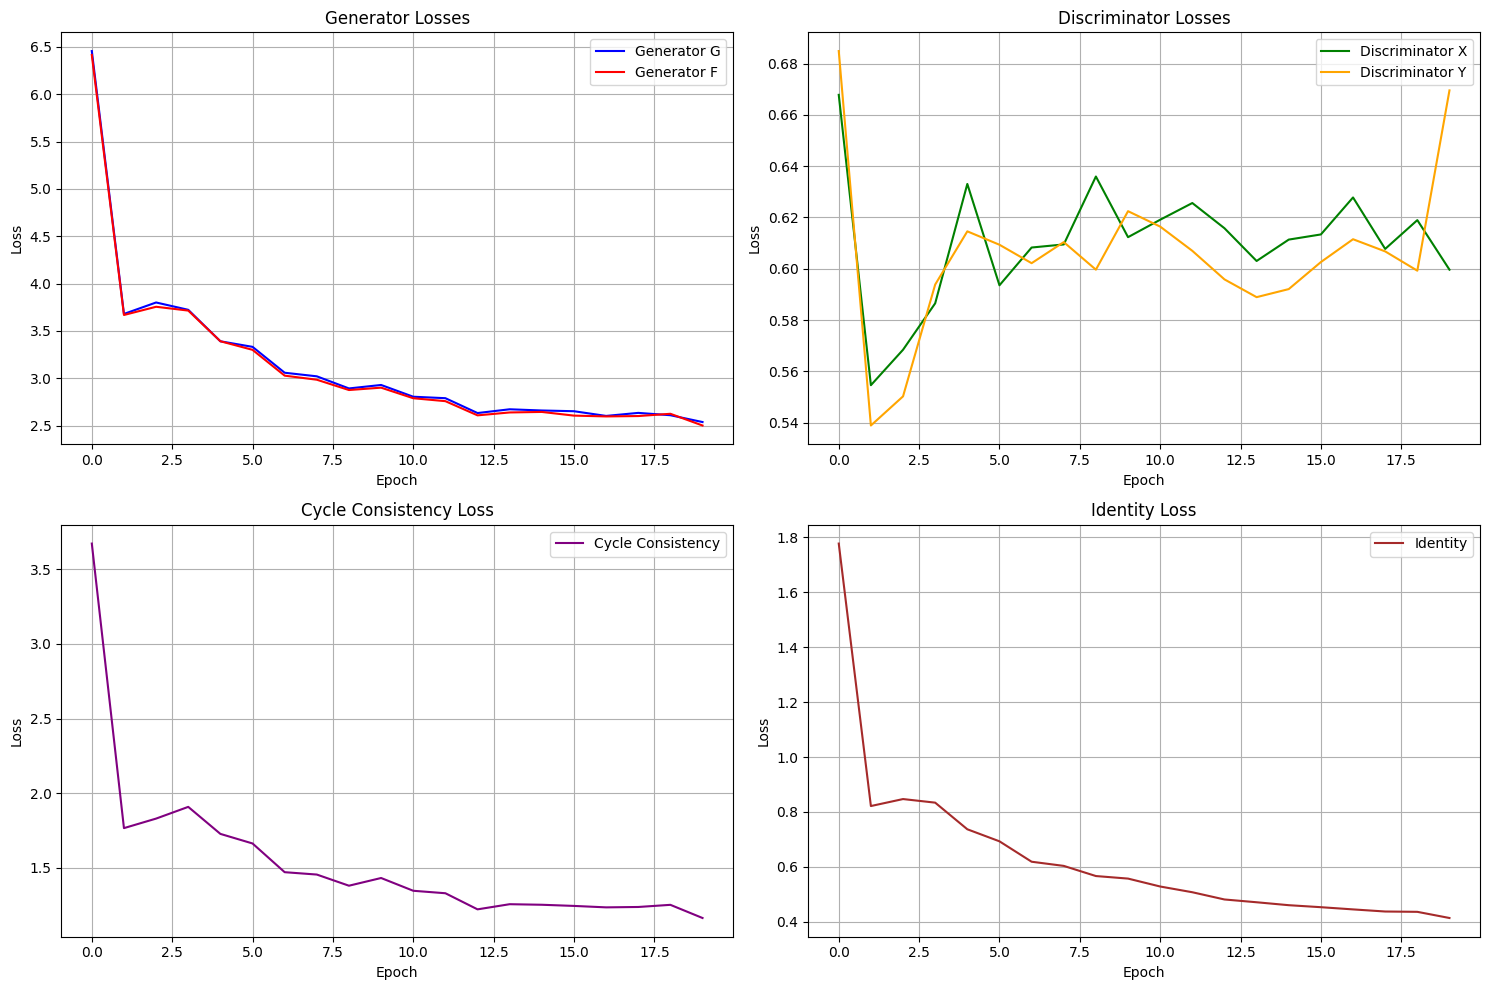

--------------------------------------------------
Epoch 21/50 - Time: 19.9s
  Gen G: 2.5414 | Gen F: 2.5784
  Disc X: 0.6280 | Disc Y: 0.5990
  Cycle: 1.2060 | Identity: 0.4183
--------------------------------------------------
Epoch 22/50 - Time: 19.8s
  Gen G: 2.5017 | Gen F: 2.4666
  Disc X: 0.6064 | Disc Y: 0.5805
  Cycle: 1.1603 | Identity: 0.4038
--------------------------------------------------
Epoch 23/50 - Time: 19.8s
  Gen G: 2.4964 | Gen F: 2.5176
  Disc X: 0.6045 | Disc Y: 0.5876
  Cycle: 1.1660 | Identity: 0.3949
--------------------------------------------------
Epoch 24/50 - Time: 19.9s
  Gen G: 2.5391 | Gen F: 2.5246
  Disc X: 0.6166 | Disc Y: 0.6329
  Cycle: 1.1724 | Identity: 0.3972
--------------------------------------------------
Epoch 25/50 - Time: 19.9s
  Gen G: 2.5294 | Gen F: 2.5071
  Disc X: 0.5918 | Disc Y: 0.5735
  Cycle: 1.1802 | Identity: 0.3914
--------------------------------------------------
Epoch 26/50 - Time: 19.8s
  Gen G: 2.5370 | Gen F: 2.4862
 

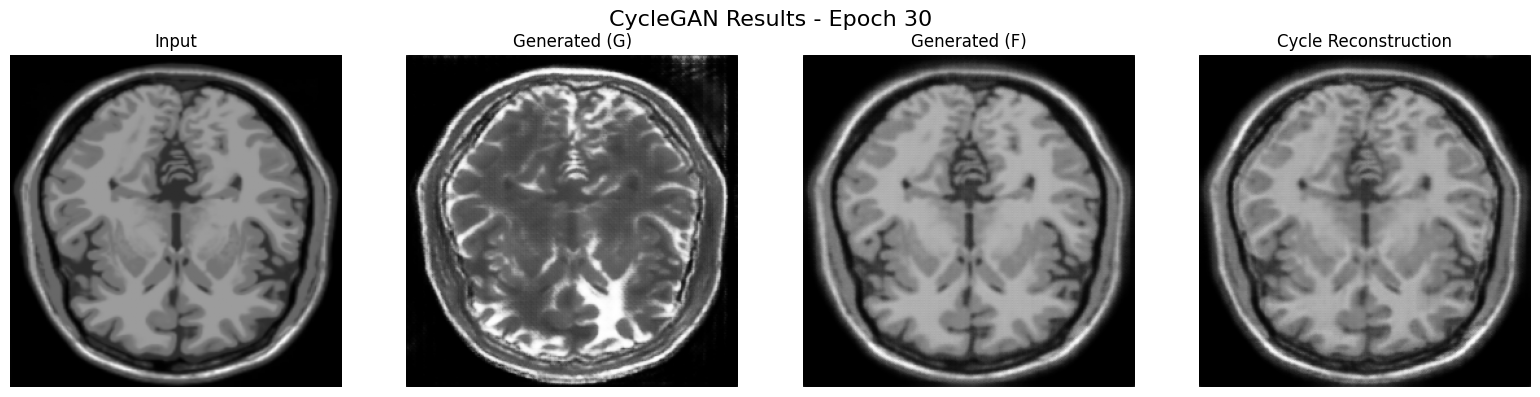

--------------------------------------------------
Epoch 31/50 - Time: 19.9s
  Gen G: 2.4531 | Gen F: 2.4104
  Disc X: 0.5951 | Disc Y: 0.5585
  Cycle: 1.1085 | Identity: 0.3639
--------------------------------------------------
Epoch 32/50 - Time: 19.9s
  Gen G: 2.4358 | Gen F: 2.3751
  Disc X: 0.5859 | Disc Y: 0.5987
  Cycle: 1.0960 | Identity: 0.3560
--------------------------------------------------


In [ ]:
# Start the complete CycleGAN training
if 'train_t1' in locals() and 'train_t2' in locals():
    print("🚀 Starting complete CycleGAN training...")
    print("This will train the full 114+ million parameter model")
    print("\nTraining configuration:")
    print(f"  - Total parameters: {total_params:,}")
    print(f"  - Epochs: {EPOCHS}")
    print(f"  - Batch size: {BATCH_SIZE}")
    print(f"  - Cycle consistency weight: {LAMBDA}")
    print(f"  - Learning rate: 2e-4")
    print(f"  - Optimizer: Adam (beta1=0.5)")
    print("\nExpected training time on T4 GPU:")
    print(f"  - {EPOCHS} epochs: ~{EPOCHS * 0.75:.1f} minutes")
    print("\nMonitoring:")
    print("  - Sample images every 10 epochs")
    print("  - Loss plots every 20 epochs")
    print("  - Real-time loss tracking")
    print("\n" + "="*60)

    # Start training
    training_history = train_cyclegan(epochs=EPOCHS)

    print("\n🎉 Training completed successfully!")
    print("\nYour CycleGAN model is now trained and ready for inference.")
    print("You can use the generators to transform T1↔T2 images.")

else:
    print("❌ Dataset not loaded. Please run the dataset preparation cells first.")
    print("\nTo start training:")
    print("1. Upload your MRI dataset")
    print("2. Run all previous cells")
    print("3. Come back to this cell")

## 7. Model Inference and Testing
Use the trained model for T1↔T2 transformations.

In [ ]:
# Inference demonstration
def demonstrate_inference():
    """Demonstrate the trained model capabilities"""

    if 'test_t1' not in locals() or 'test_t2' not in locals():
        print("❌ Test datasets not available. Please run the data preparation cells first.")
        return

    print("🔬 Demonstrating trained CycleGAN inference...")
    print("\nTesting bidirectional transformation capabilities:")

    # Get test samples
    test_t1_sample = next(iter(test_t1.take(1)))
    test_t2_sample = next(iter(test_t2.take(1)))

    # T1 → T2 transformation
    print("\n1. T1 → T2 Transformation:")
    fake_t2 = generator_g(test_t1_sample, training=False)
    cycle_t1 = generator_f(fake_t2, training=False)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert for display
    real_t1_display = (test_t1_sample[0, :, :, 0] + 1.0) / 2.0
    fake_t2_display = (fake_t2[0, :, :, 0] + 1.0) / 2.0
    cycle_t1_display = (cycle_t1[0, :, :, 0] + 1.0) / 2.0

    axes[0].imshow(real_t1_display, cmap='gray')
    axes[0].set_title('Real T1')
    axes[0].axis('off')

    axes[1].imshow(fake_t2_display, cmap='gray')
    axes[1].set_title('Generated T2')
    axes[1].axis('off')

    axes[2].imshow(cycle_t1_display, cmap='gray')
    axes[2].set_title('Cycle Reconstructed T1')
    axes[2].axis('off')

    plt.suptitle('T1 → T2 → T1 Transformation', fontsize=16)
    plt.tight_layout()
    plt.show()

    # T2 → T1 transformation
    print("\n2. T2 → T1 Transformation:")
    fake_t1 = generator_f(test_t2_sample, training=False)
    cycle_t2 = generator_g(fake_t1, training=False)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert for display
    real_t2_display = (test_t2_sample[0, :, :, 0] + 1.0) / 2.0
    fake_t1_display = (fake_t1[0, :, :, 0] + 1.0) / 2.0
    cycle_t2_display = (cycle_t2[0, :, :, 0] + 1.0) / 2.0

    axes[0].imshow(real_t2_display, cmap='gray')
    axes[0].set_title('Real T2')
    axes[0].axis('off')

    axes[1].imshow(fake_t1_display, cmap='gray')
    axes[1].set_title('Generated T1')
    axes[1].axis('off')

    axes[2].imshow(cycle_t2_display, cmap='gray')
    axes[2].set_title('Cycle Reconstructed T2')
    axes[2].axis('off')

    plt.suptitle('T2 → T1 → T2 Transformation', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate cycle consistency metrics
    cycle_loss_t1 = tf.reduce_mean(tf.abs(test_t1_sample - cycle_t1))
    cycle_loss_t2 = tf.reduce_mean(tf.abs(test_t2_sample - cycle_t2))

    print(f"\n📊 Cycle Consistency Metrics:")
    print(f"  T1 cycle loss: {cycle_loss_t1:.4f}")
    print(f"  T2 cycle loss: {cycle_loss_t2:.4f}")
    print(f"  Average cycle loss: {(cycle_loss_t1 + cycle_loss_t2) / 2:.4f}")

    print("\n✅ Inference demonstration completed!")
    print("Your CycleGAN model is working and can perform bidirectional T1↔T2 transformations.")

# Run inference demonstration
demonstrate_inference()



### Model Specifications:
- **Generator G (T1→T2)**: 54.4M parameters
- **Generator F (T2→T1)**: 54.4M parameters  
- **Discriminator X (T1)**: 2.8M parameters
- **Discriminator Y (T2)**: 2.8M parameters
- **Total**: 114,344,708 parameters

### Next Steps:
1. **Experiment** with different hyperparameters
2. **Train longer** for higher quality results
3. **Test on new images** to evaluate generalization

### Important Notes:
- This is for **research and educational purposes only**
- **Clinical validation required** before any medical application
- **Radiologist assessment needed** for diagnostic use

